<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_ReinfLearn_Work/blob/main/TP01/taxi_qlearning_v05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 8.6 MB/s eta 0:00:00


In [3]:
## Imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display, clear_output
import time


In [4]:
## Constants

RENDER_RGB = 'rgb_array'
RENDER_ANSI = 'ansi'

GAME_TAXI = 'Taxi-v3'

In [5]:
## create env (rgb or ansi)

def create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=False):
    if pPrint:
        print('[create_env] Creating environment...')
    try:
        env = gym.make(pGame, render_mode=pRenderMode)
        if pPrint:
            print('[create_env] Environment created successfully!')
        return env
    except Exception as e:
        print('[create_env] Error creating environment:', e)

## Functions to decode state (0-499) into taxi position, passenger position, destination position

In [13]:
## transform passenger and destination into (row, col)
def passenger_to_coordinates(location):
    if location == 0: return (0, 0)
    elif location == 1: return (0, 4)
    elif location == 2: return (4, 0)
    elif location == 3: return (4, 3)
    elif location == 4: return (4, 4)
    elif location == 5: return (-1, -1)  # Special case for inside the taxi
    else: raise ValueError("Invalid location")

def destination_to_coordinates(destination):
    if destination == 0: return (0, 0)
    elif destination == 1: return (0, 4)
    elif destination == 2: return (4, 0)
    elif destination == 3: return (4, 4)
    else: raise ValueError("Invalid destination")

def decode_state(pState, pPrint=False):
    # Taxi position
    taxi_row = pState // (5 * 5 * 4)  # 5 rows * 5 cols * 4 destinations (passenger_loc is 5 or less)
    pState %= 5 * 5 * 4

    taxi_col = pState // (5 * 4)  # 5 cols * 4 destinations
    pState %= 5 * 4

    # Passenger location
    passenger_loc = pState // 4  # passenger location is 0-5
    if passenger_loc == 5:
        passenger_loc = -1  # -1 represents the passenger is in the taxi

    # Destination
    destination = pState % 4  # destination is 0-3

    if pPrint:
        print(f'taxi position: {(taxi_row, taxi_col)}')
        print(f'passenger: {passenger_to_coordinates(passenger_loc)}')
        print(f'destination: {destination_to_coordinates(destination)}')


    return taxi_row, taxi_col, passenger_loc, destination

def plot_reward_evolution(rewards
                          , pXLabel = 'Episode'
                          , pYLabel = 'Reward'
                          , pTitle='Reward Evolution during Training'):
  """Plots the evolution of rewards over episodes.

  Args:
    rewards: A list of rewards obtained during training.
  """
  plt.clf() #clear cell
  plt.plot(rewards)
  plt.xlabel(pXLabel)
  plt.ylabel(pYLabel)
  plt.title(pTitle)

  # Calculate tick positions for 10 evenly spaced labels
  num_ticks = 10
  x_min = 0  # Assume x-axis starts at 0
  x_max = len(rewards) - 1  # Assume x-axis ends at the last data point
  tick_positions = np.linspace(x_min, x_max, num_ticks, dtype=int)

   # Set x-axis ticks and labels
  plt.xticks(tick_positions, tick_positions)  # Set both positions and labels


  plt.show()

  ## only used for rgb (graphical) rendering
def display_rgb(pEnv=create_env(), pPrintMultipleFrames=False):
    if pEnv.render_mode == RENDER_RGB:
        # Capture the frame for rendering
        frame = env.render()

        # Display the frame in Jupyter
        plt.imshow(frame)
        plt.axis('off')
        display(plt.gcf())
        if pPrintMultipleFrames:
            clear_output(wait=True)  # Clears the output for each frame
        time.sleep(5)  # Adjust for slower or faster playback


# Q-learning

In [14]:


def create_q_table(env):
  """Creates a Q-table with all values initialized to 0.

  Args:
    env: The Gymnasium environment.

  Returns:
    A NumPy array representing the Q-table.
  """
  return np.zeros([env.observation_space.n, env.action_space.n])



def get_policy(q_table, state, epsilon):
  """Selects an action using the epsilon-greedy policy.

  Args:
    q_table: The Q-table containing learned values.
    state: The current state of the environment.
    epsilon: The exploration rate.

  Returns:
    The action selected by the policy.
  """
  if np.random.uniform(0, 1) < epsilon:
    action = env.action_space.sample()  # Explore action space
  else:
    action = np.argmax(q_table[state])  # Exploit learned values
  return action



def train_q_learning(env
                     , q_table
                     , alpha=0.1
                     , gamma=0.9
                     , epsilon=1.0
                     , episodes=100000
                     , pPrint=False
                     ):
  """Trains the Q-learning agent.

  Args:
    env: The Gymnasium environment.
    q_table: The Q-table to update.
    alpha: The learning rate.
    gamma: The discount factor.
    epsilon: The exploration rate.
    episodes: The number of training episodes.

    Returns:
    A tuple containing the trained Q-table and the list of rewards per episode.
  """

  rewards = []

  # List to store rewards per episode
  all_rewards_per_episode = []

  # Example decay rate
  epsilon_decay = 0.9999


  for i in range(1, episodes + 1):
    state = env.reset()[0]
    epochs, penalties, reward = 0, 0, 0
    done = False


    while not done:

      action = get_policy(q_table, state, epsilon)

      # Decay epsilon over time:
      epsilon *= epsilon_decay
      epsilon = max(epsilon, 0.1) # set the min epsilon

      ## step
      next_state, reward, done, truncated, info = env.step(action)


      old_value = q_table[state, action]
      next_max = np.max(q_table[next_state])

      ## 'learning' (update q_table)
      new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
      q_table[state, action] = new_value

      # reward -10 = leaving passenger somewhere else than destination
      if reward == -10:
        penalties += 1

      state = next_state
      epochs += 1

      rewards.append(reward)



    if pPrint:
      print("****************************************************")
      print(f"Episode: {i}")
      print(f"Timesteps taken: {epochs}")
      print(f"Penalties incurred: {penalties}")


    all_rewards_per_episode.append(np.mean(rewards)) # Calculating avg. reward per episode

    ten_pct_print = int(episodes/10)

    if i % (ten_pct_print) == 0:
      #print(f"Episode: {i}")
      avg_reward_last_100 = np.mean(all_rewards_per_episode[-ten_pct_print:]) # Calculating avg. reward for the last 100 episodes
      print(f"Episode: {i}, Average reward (last {ten_pct_print} episodes): {avg_reward_last_100}, current epsilon: {epsilon}")


    #if i % 1000 == 0:
     # plot_reward_evolution(rewards)

  print("Training finished.\n")
  return q_table, all_rewards_per_episode  # Return the Q-table and reward history




def evaluate_agent(env
                   , q_table
                   , episodes=100
                   , pPrint=False
                   , pPlotGame=False
                   , pPlotGraphs=False):
  """Evaluates the trained agent.

  Args:
    env: The Gymnasium environment.
    q_table: The trained Q-table.
    episodes: The number of evaluation episodes.

  Returns:
    The average reward over the evaluation episodes.
  """

  if pPrint:
      print('Evaluating agent...')

  arr_avg_rewards = []
  arr_total_rewards = []
  arr_total_steps = []
  arr_penalties = []

  total_rewards = 0
  for ep in range(episodes):
    state = env.reset()[0]
    done = False
    episode_reward = 0

    steps_so_far = 0
    penalties = 0

    ## render game image
    if pPlotGame:
      display_rgb(env, pPrintMultipleFrames=True)

    while not done :
      action = np.argmax(q_table[state])

      ## step
      state, reward, done, truncated, info = env.step(action)

      ## render game image
      if pPlotGame:
        display_rgb(env, pPrintMultipleFrames=True)

      steps_so_far +=1

      if steps_so_far>30:
        print(f'Too many steps {steps_so_far} Bye')
        done = True

      episode_reward += reward

      if reward == -10:
        penalties += 1
        if penalties >3:
          print(f'Too many wrong actions {penalties}. Bye!')
          done = True

      reward_per_step = episode_reward / steps_so_far


      if (pPrint and (steps_so_far % 50) ==0):
        print(f'steps_so_far: {steps_so_far}')
        print(f'Reward/step in episode [{ep}]: {reward_per_step}')

    total_rewards += episode_reward

    if pPrint:
      print(f"Episode [{ep}] [reward]: {episode_reward} - [reward/step]: {reward_per_step} - [penalties]: {penalties} - [total_steps]: {steps_so_far}")


    arr_total_steps.append(steps_so_far)
    arr_penalties.append(penalties)
    arr_avg_rewards.append(reward_per_step)
    arr_total_rewards.append(episode_reward)

  print(f"Results after {episodes} episodes:")
  print(f'len(arr_avg_rewards): {len(arr_avg_rewards)} ')
  print(f'len(arr_total_rewards): {len(arr_total_rewards)} ')
  print(f'len(arr_total_steps): {len(arr_total_steps)} ')
  print(f'len(arr_penalties): {len(arr_penalties)} ')

  if pPlotGraphs:
    plot_reward_evolution(arr_avg_rewards
                          , pYLabel='Average Reward'
                          , pTitle='Average Reward evolution')
    plot_reward_evolution(arr_total_rewards
                          , pYLabel='Total Rewards'
                          , pTitle='Total Rewards evolution')
    plot_reward_evolution(arr_total_steps
                          , pYLabel='Total Steps'
                          , pTitle='Total Steps evolution')
    plot_reward_evolution(arr_penalties
                          , pYLabel='Penalties'
                          , pTitle='Penalties evolution')

  return total_rewards / episodes



In [9]:
# Main execution
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=5000)
q_table2, rewards2 = train_q_learning(env, create_q_table(env), episodes=7500)

# Now you have q_table1, q_table2, rewards1, and rewards2 for comparison


[create_env] Creating environment...
[create_env] Environment created successfully!
Episode: 500, Average reward (last 500 episodes): -1.70138638638553, current epsilon: 0.1
Episode: 1000, Average reward (last 500 episodes): -1.399890652769363, current epsilon: 0.1
Episode: 1500, Average reward (last 500 episodes): -1.2807804657675237, current epsilon: 0.1
Episode: 2000, Average reward (last 500 episodes): -1.182378024863212, current epsilon: 0.1
Episode: 2500, Average reward (last 500 episodes): -1.0962086605575705, current epsilon: 0.1
Episode: 3000, Average reward (last 500 episodes): -1.0220773710101847, current epsilon: 0.1
Episode: 3500, Average reward (last 500 episodes): -0.9543966085835318, current epsilon: 0.1
Episode: 4000, Average reward (last 500 episodes): -0.8942691356582981, current epsilon: 0.1
Episode: 4500, Average reward (last 500 episodes): -0.8417549438108901, current epsilon: 0.1
Episode: 5000, Average reward (last 500 episodes): -0.7927025905876494, current epsi

In [ ]:
## q_table 1
average_reward = evaluate_agent(env
                                , q_table1
                                , episodes=200
                                ,  pPrint=True
                                )

print(f"Average reward: {average_reward}")



Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 


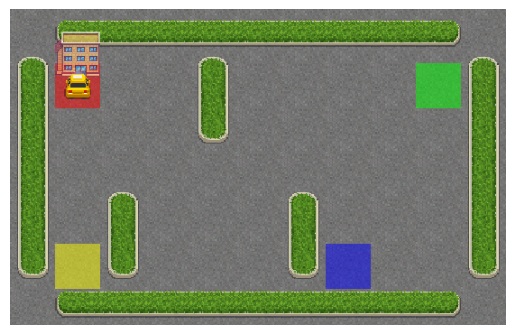

In [15]:
average_reward = evaluate_agent(env
                                , q_table1
                                , episodes=1
                                ,  pPrint=False
                                , pPlotGame=True)

Evaluating agent...
Episode [0] [reward]: 4 - [reward/step]: 0.23529411764705882 - [penalties]: 0 - [total_steps]: 17
Episode [1] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [2] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [3] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [4] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [5] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [6] [reward]: 14 - [reward/step]: 2.0 - [penalties]: 0 - [total_steps]: 7
Episode [7] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [8] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [9] [reward]: 10 - [reward/step]: 0.9090909090909091 - [penalties]: 0 - [total_steps]: 11
Episode [10] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [11] [reward]: 9

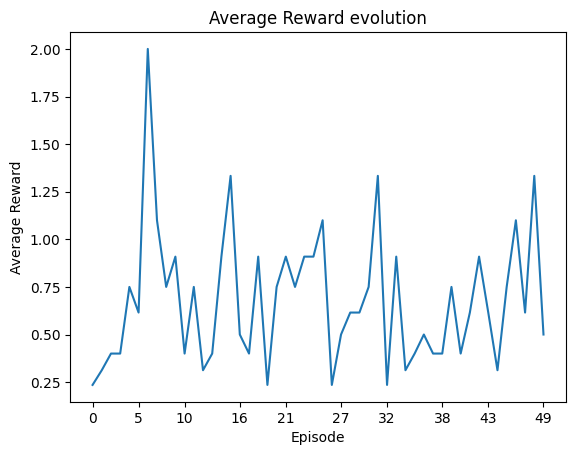

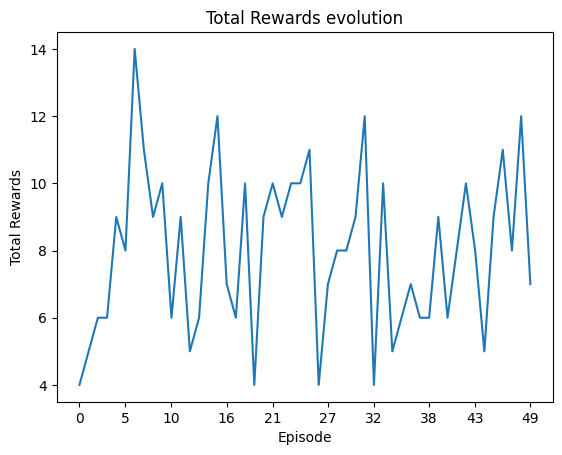

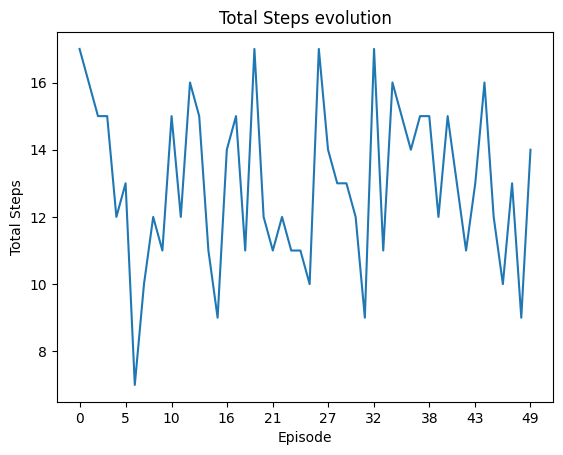

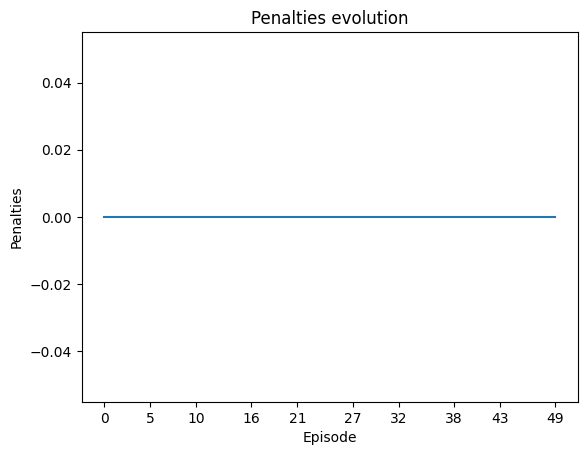

Average reward: 8.02


In [ ]:
## q_table 2
average_reward = evaluate_agent(env
                                , q_table2
                                , episodes=50
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Combining training 1 & 2.

In [ ]:
# Main execution
env = gym.make("Taxi-v3")
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=6000)
q_table2, rewards2 = train_q_learning(env, q_table1, episodes=10000)

# Now you have q_table1, q_table2, rewards1, and rewards2 for comparison


Episode: 600, Average reward (last 600 episodes): -1.6732212651033413, current epsilon: 0.1
Episode: 1200, Average reward (last 600 episodes): -1.35852463079159, current epsilon: 0.1
Episode: 1800, Average reward (last 600 episodes): -1.2289412995547517, current epsilon: 0.1
Episode: 2400, Average reward (last 600 episodes): -1.1210477315858653, current epsilon: 0.1
Episode: 3000, Average reward (last 600 episodes): -1.0264795696210192, current epsilon: 0.1
Episode: 3600, Average reward (last 600 episodes): -0.9461386517414003, current epsilon: 0.1
Episode: 4200, Average reward (last 600 episodes): -0.8768755254103117, current epsilon: 0.1
Episode: 4800, Average reward (last 600 episodes): -0.8157817349624736, current epsilon: 0.1
Episode: 5400, Average reward (last 600 episodes): -0.7601634676598433, current epsilon: 0.1
Episode: 6000, Average reward (last 600 episodes): -0.710220994271466, current epsilon: 0.1
Training finished.

Episode: 1000, Average reward (last 1000 episodes): -1

Evaluating agent...
Episode [0] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [1] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [2] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [3] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [4] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [5] [reward]: 14 - [reward/step]: 2.0 - [penalties]: 0 - [total_steps]: 7
Episode [6] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [7] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [8] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [9] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [10] [reward]: 13 - [reward/step]: 1.625 - [penalties]: 0 - [total_steps]: 8
Episode [11] [reward]: 7 - [reward/step]: 0.5 - [penalt

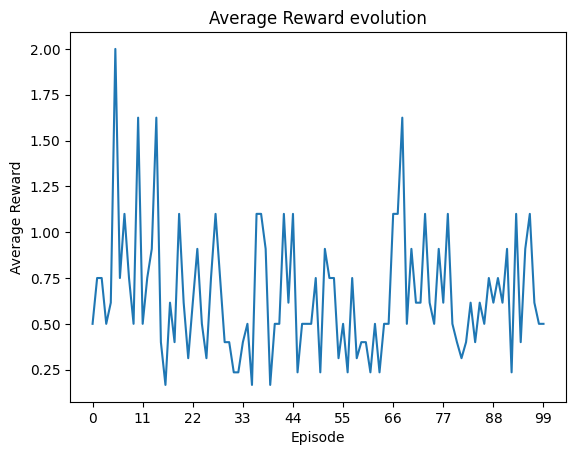

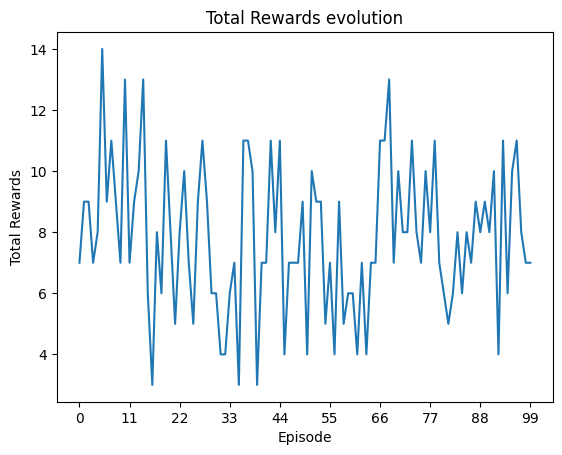

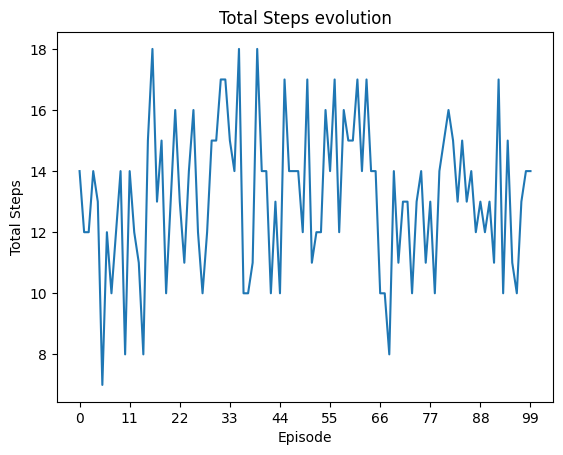

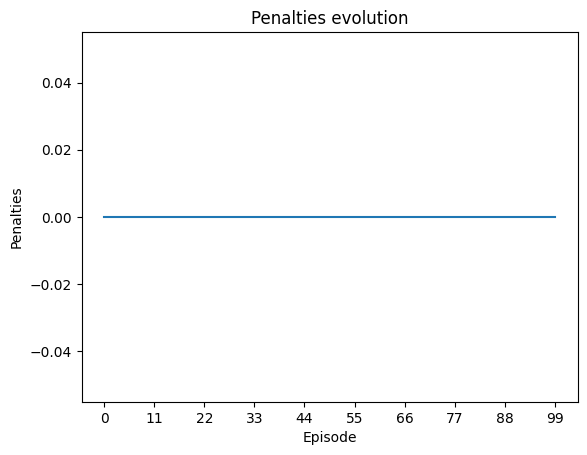

Average reward: 7.84


In [ ]:
## q_table 1_2
average_reward = evaluate_agent(env
                                , q_table2
                                , episodes=100
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

3 training sessions

In [ ]:
# Main execution
env = gym.make("Taxi-v3")
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=7000)
q_table2, rewards2 = train_q_learning(env, q_table1, episodes=2000)
q_table3, rewards3 = train_q_learning(env, q_table2, episodes=6000)

# Now you have q_table1, q_table2, rewards1, and rewards2 for comparison


Episode: 700, Average reward (last 700 episodes): -1.6196390065743487, current epsilon: 0.1
Episode: 1400, Average reward (last 700 episodes): -1.324862498219506, current epsilon: 0.1
Episode: 2100, Average reward (last 700 episodes): -1.1837272731894875, current epsilon: 0.1
Episode: 2800, Average reward (last 700 episodes): -1.0670595661321771, current epsilon: 0.1
Episode: 3500, Average reward (last 700 episodes): -0.9718416074978601, current epsilon: 0.1
Episode: 4200, Average reward (last 700 episodes): -0.8895716060713572, current epsilon: 0.1
Episode: 4900, Average reward (last 700 episodes): -0.8171801976041266, current epsilon: 0.1
Episode: 5600, Average reward (last 700 episodes): -0.7554358741849844, current epsilon: 0.1
Episode: 6300, Average reward (last 700 episodes): -0.7006612028790714, current epsilon: 0.1
Episode: 7000, Average reward (last 700 episodes): -0.6510872571488517, current epsilon: 0.1
Training finished.

Episode: 200, Average reward (last 200 episodes): -2

Evaluating agent...
Episode [0] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [1] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [2] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [3] [reward]: 4 - [reward/step]: 0.23529411764705882 - [penalties]: 0 - [total_steps]: 17
Episode [4] [reward]: 14 - [reward/step]: 2.0 - [penalties]: 0 - [total_steps]: 7
Episode [5] [reward]: 4 - [reward/step]: 0.23529411764705882 - [penalties]: 0 - [total_steps]: 17
Episode [6] [reward]: 12 - [reward/step]: 1.3333333333333333 - [penalties]: 0 - [total_steps]: 9
Episode [7] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [8] [reward]: 4 - [reward/step]: 0.23529411764705882 - [penalties]: 0 - [total_steps]: 17
Episode [9] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [10] [reward]: 13 - [reward/step]: 1.625 - [penalties]: 0 - [total_steps]:

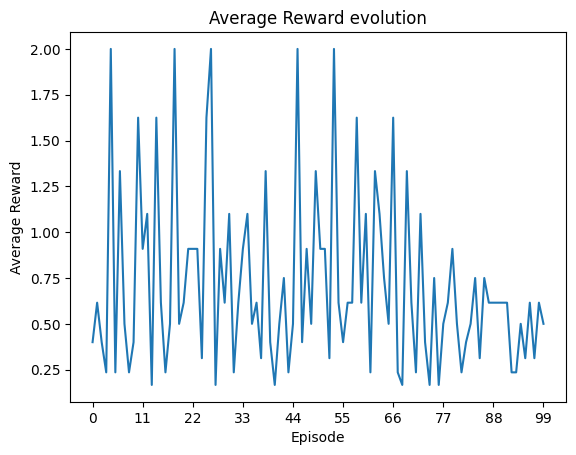

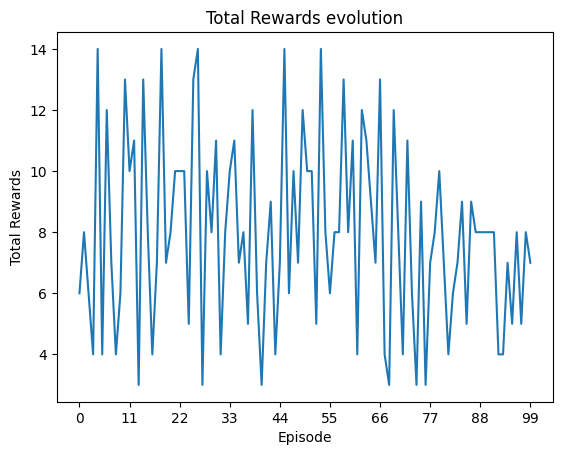

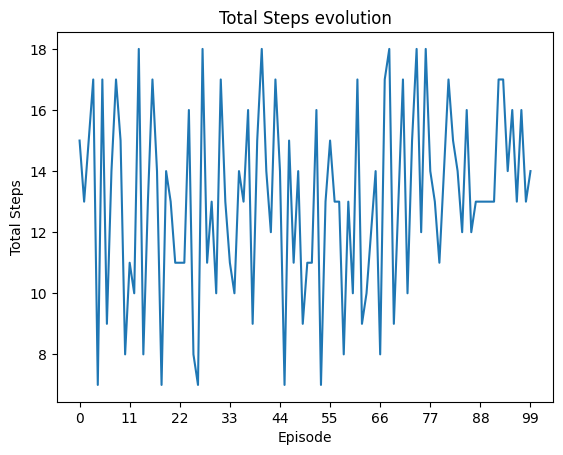

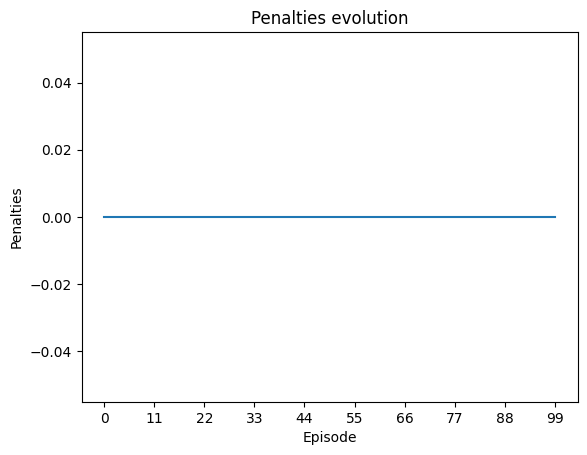

Average reward: 7.93


In [ ]:
## q_table 1_2_3
average_reward = evaluate_agent(env
                                , q_table3
                                , episodes=100
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Not enough training example

In [ ]:
# Main execution
env = gym.make("Taxi-v3")
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=600)
q_table2, rewards2 = train_q_learning(env, q_table1, episodes=1000)

# Now you have q_table1, q_table2, rewards1, and rewards2 for comparison


Episode: 60, Average reward (last 60 episodes): -2.5409300739927887, current epsilon: 0.1
Episode: 120, Average reward (last 60 episodes): -1.8827403105054696, current epsilon: 0.1
Episode: 180, Average reward (last 60 episodes): -1.7209680389103685, current epsilon: 0.1
Episode: 240, Average reward (last 60 episodes): -1.6410114387007158, current epsilon: 0.1
Episode: 300, Average reward (last 60 episodes): -1.5908352400928378, current epsilon: 0.1
Episode: 360, Average reward (last 60 episodes): -1.5527887618271639, current epsilon: 0.1
Episode: 420, Average reward (last 60 episodes): -1.5208023226593352, current epsilon: 0.1
Episode: 480, Average reward (last 60 episodes): -1.494970431004813, current epsilon: 0.1
Episode: 540, Average reward (last 60 episodes): -1.4727645300103438, current epsilon: 0.1
Episode: 600, Average reward (last 60 episodes): -1.4528214836358617, current epsilon: 0.1
Training finished.

Episode: 100, Average reward (last 100 episodes): -3.0426109899841385, c

Evaluating agent...
Episode [0] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [1] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Too many steps 31 Bye
Episode [2] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Episode [3] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [4] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [5] [reward]: 3 - [reward/step]: 0.16666666666666666 - [penalties]: 0 - [total_steps]: 18
Episode [6] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [7] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [8] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [9] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [10] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Ep

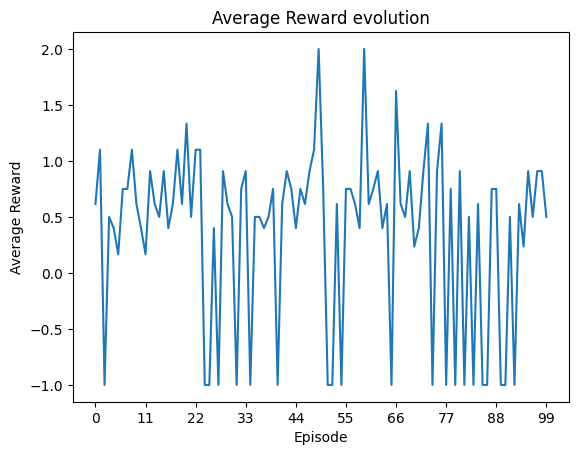

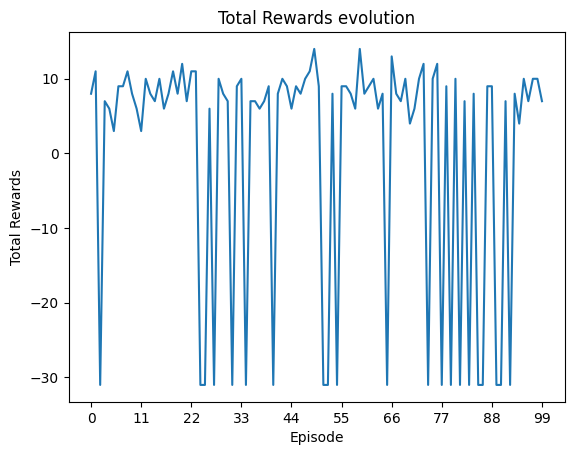

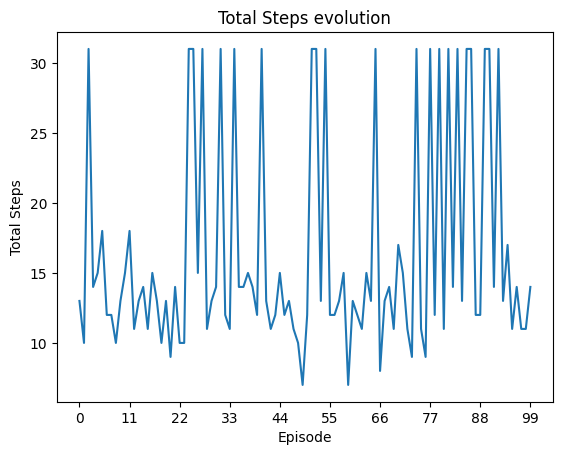

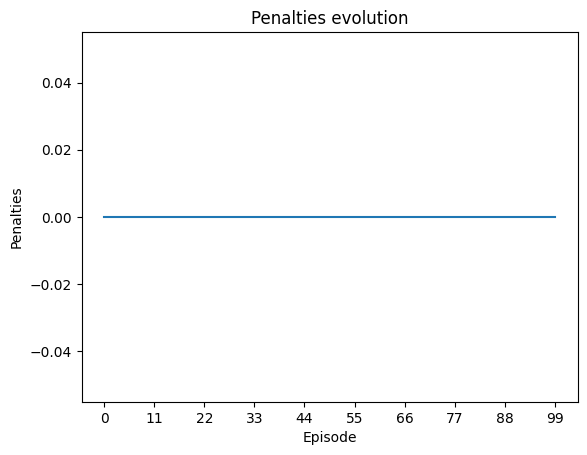

Average reward: 0.21


In [ ]:
## q_table 1_2
average_reward = evaluate_agent(env
                                , q_table2
                                , episodes=100
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")